Two options: either I refresh the velocity with a certain rate or I take $-v_sample_prime$ which grows longer thanks to the gradient.

In [41]:
import numpy as np
from scipy.stats import multivariate_normal
from Zappa.zappa import zappa_projectv, zappa_sampling
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import logf_Jacobian
from utils import logp as logp_scale
from utils import quick_MVN_scatter, quick_MVN_marginals
import matplotlib.pyplot as plt
from utils import normalize
from Zappa.zappa import project
from Zappa.zappa import zappa_adaptive, zappa_projectv_adaptive
from utils import update_scale_sa
from ManifoldHMCAlgorithms.mixture_manifoldhmc import MixtureManifoldHMCProjectv, MixtureManifoldHMC
import scipy.stats as ss

In [54]:
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
s = 0.5
a_guess=1.0
rate=0.5
n = 500
tol = 1.48e-08
incr=0.1
x = mu - incr #target.rvs()
z = target.pdf(x)
ellipse = RotatedEllipse(mu, Sigma, z)
logf = lambda xy: logf_Jacobian(xy, Sigma)
logp = lambda xy: logp_scale(xy, s)

In [49]:
samples_normal = zappa_sampling(x, ellipse, logf, logp, n, s, tol, a_guess)

In [50]:
xlims = [np.min(samples_normal[:, 0])-incr, np.max(samples_normal[:, 0]) + incr]
ylims = [np.min(samples_normal[:, 1])-incr, np.max(samples_normal[:, 1]) + incr]

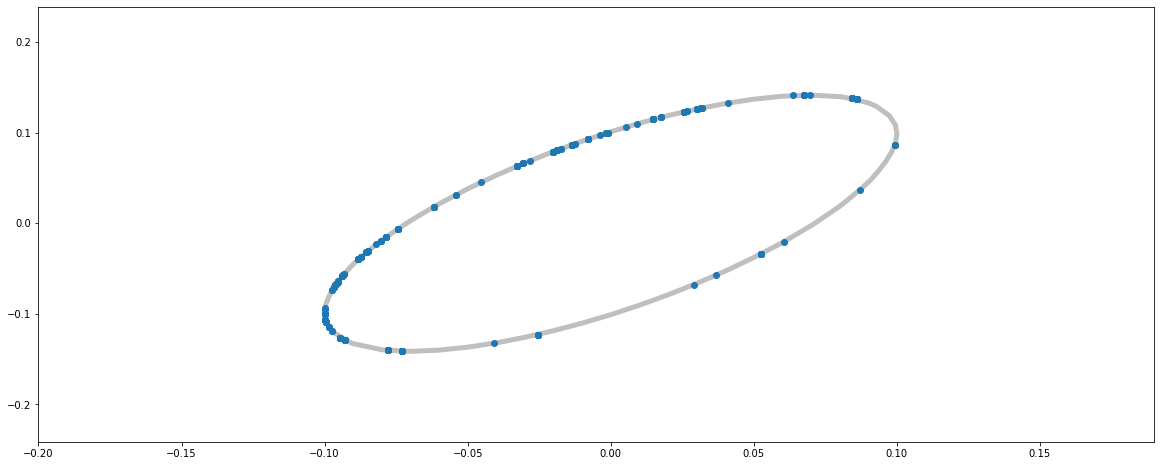

In [51]:
quick_MVN_scatter(samples_normal, target, levels=[z], alpha=0.5, xlims=xlims, ylims=ylims, step=incr/10)

In [55]:
samples = zappa_projectv(x, ellipse, logf, logp, n, s, tol, a_guess, refreshrate=rate)

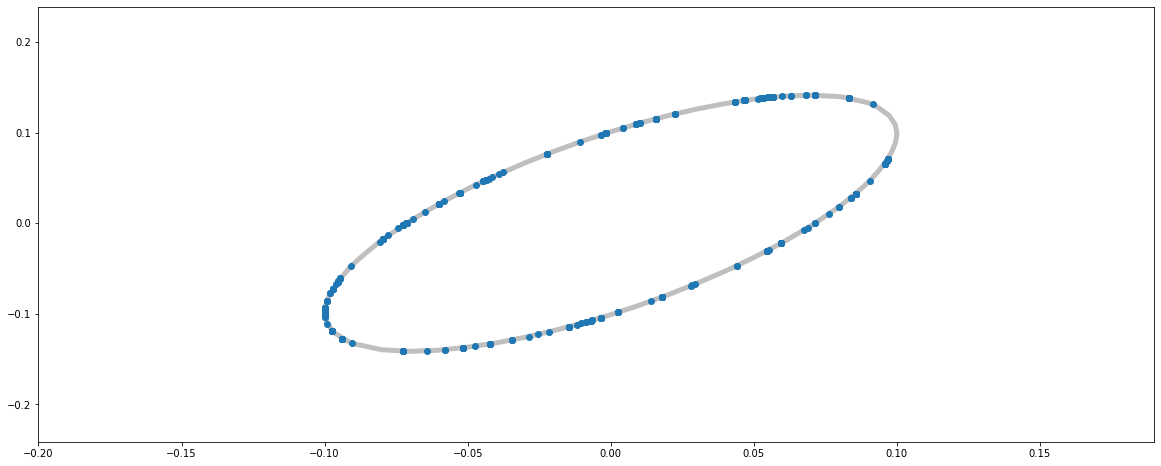

In [56]:
quick_MVN_scatter(samples, target, levels=[z], alpha=0.5, xlims=xlims, ylims=ylims, step=incr/10)

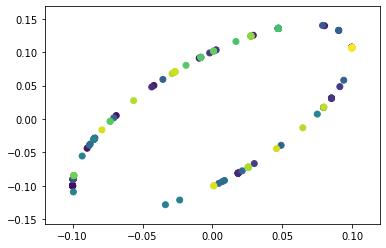

In [11]:
plt.scatter(*samples.T, c=np.arange(len(samples)))

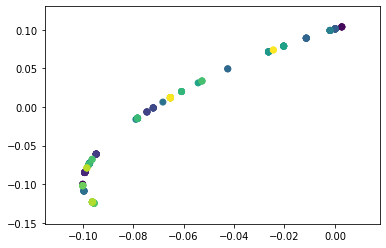

In [12]:
plt.scatter(*samples_normal.T, c=np.arange(len(samples_normal)))

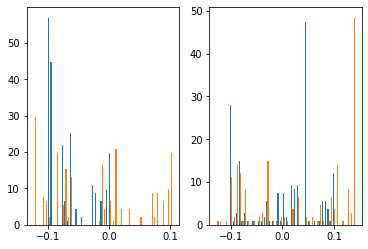

In [13]:
fig, ax = plt.subplots(ncols=2)
_ = ax[0].hist(samples_normal, bins=50, density=True)
_ = ax[1].hist(samples, bins=50, density=True)

# Adaptive

In [13]:
ap_star = 0.6
s = 0.5
rate=0.3 #refreshment rate
x = target.rvs()
z = target.pdf(x)
ellipse = RotatedEllipse(mu, Sigma, z)

In [14]:
samples_adaptive = zappa_adaptive(x, ellipse, logf, 100, s, tol, a_guess, ap_star, update_scale_sa)

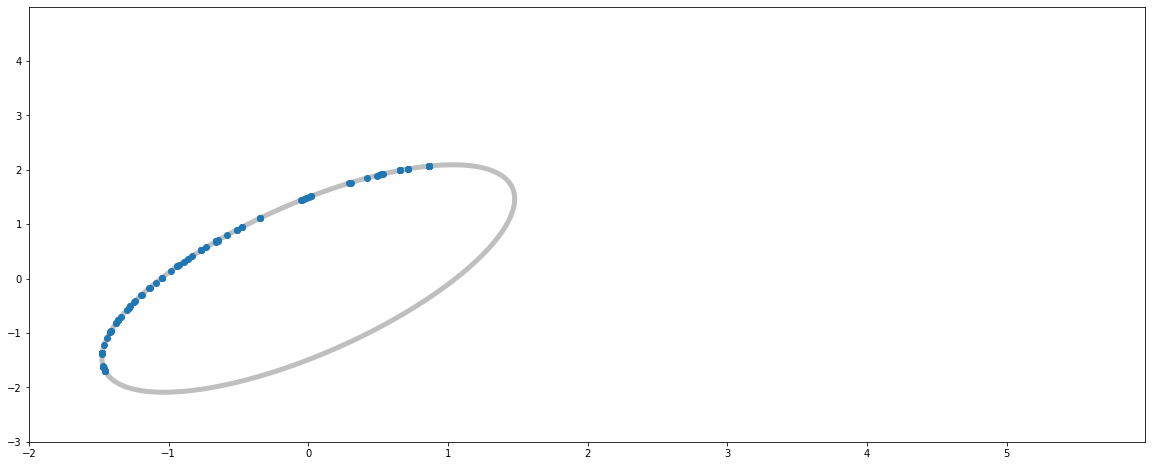

In [15]:
quick_MVN_scatter(samples_adaptive, target, levels=[z], alpha=0.5)

In [16]:
samples_adaptive_proj = zappa_projectv_adaptive(x, ellipse, logf, 100, s, tol, a_guess, ap_star, update_scale_sa, refreshrate=rate)

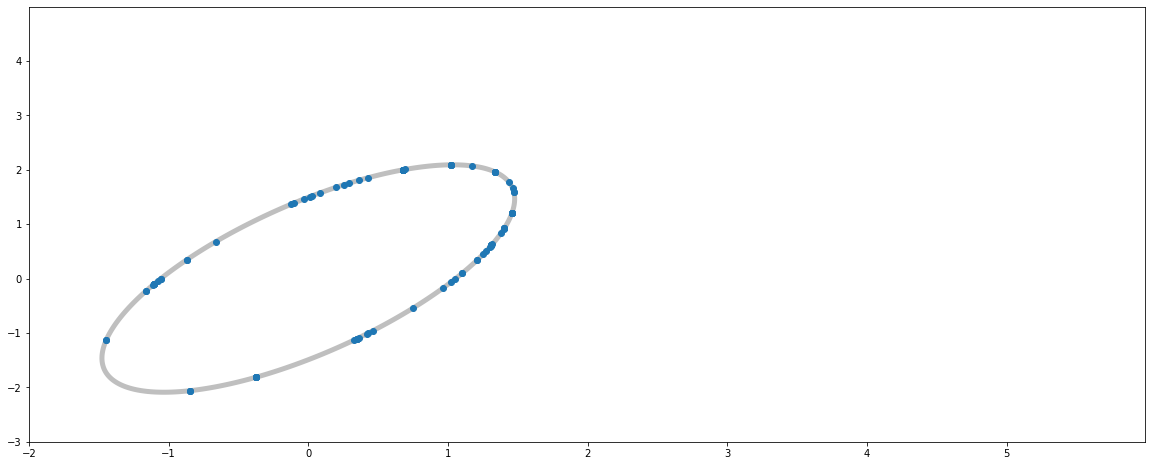

In [17]:
quick_MVN_scatter(samples_adaptive_proj, target, levels=[z], alpha=0.5)

# mixture manifold

In [57]:
alpha=0.2
M = np.eye(2)
T = 5
epsilon = 0.1
N = 100000
n = 1
m = 30
rate = 0.5

In [58]:
mhmc_samples = MixtureManifoldHMC(x, alpha, N, n, m, Sigma, mu, T, epsilon, M, s=s, tol=tol)

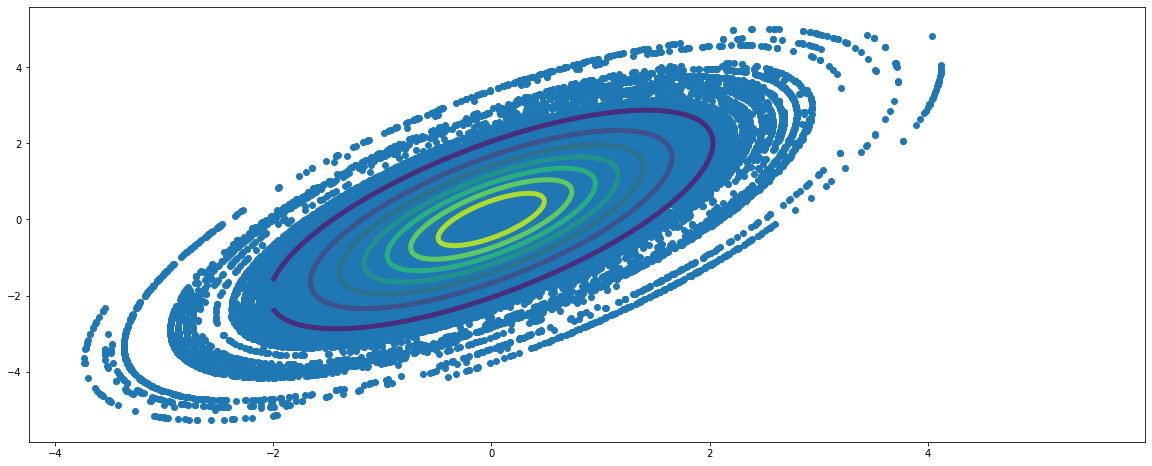

In [59]:
quick_MVN_scatter(mhmc_samples, target)

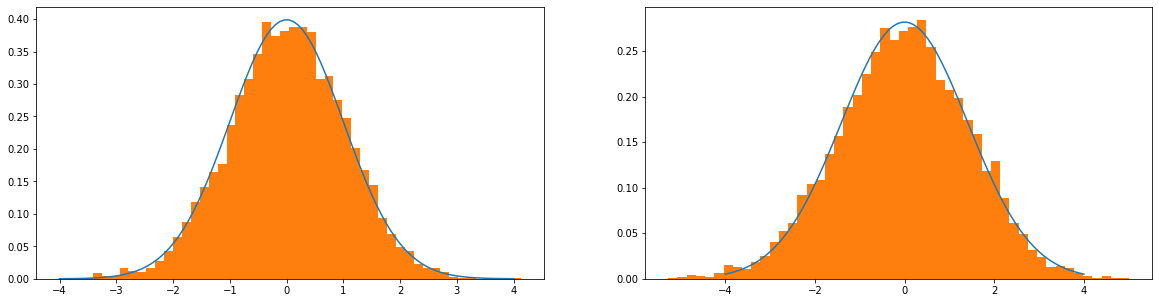

In [60]:
quick_MVN_marginals(mhmc_samples, target)

In [61]:
mhmc_samples_pv = MixtureManifoldHMCProjectv(x, alpha, N, n, m, Sigma, mu, T, epsilon, M, s=s, tol=tol, refreshrate=rate)

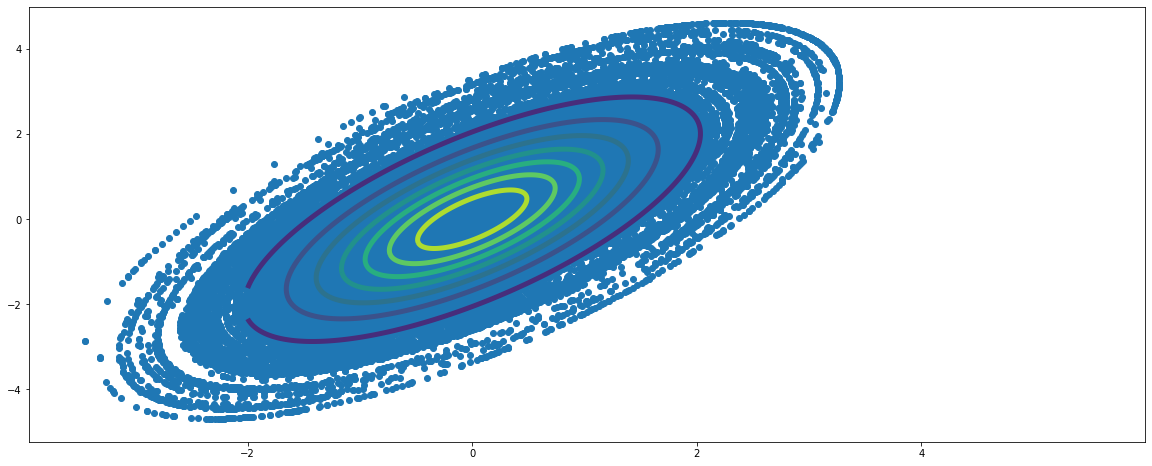

In [62]:
quick_MVN_scatter(mhmc_samples_pv, target)

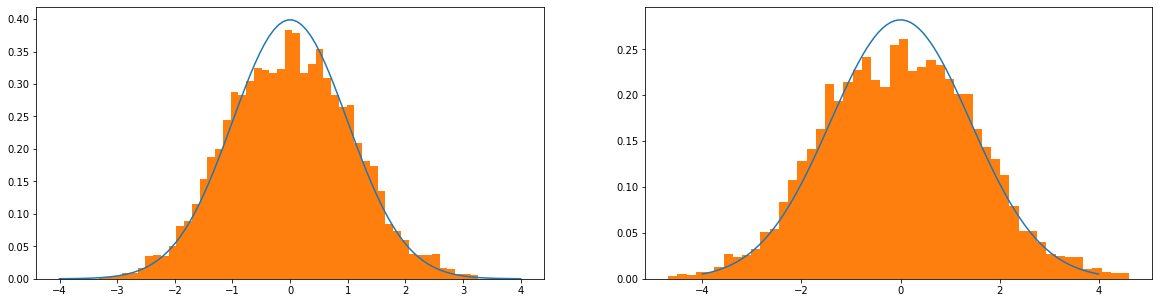

In [63]:
quick_MVN_marginals(mhmc_samples_pv, target)

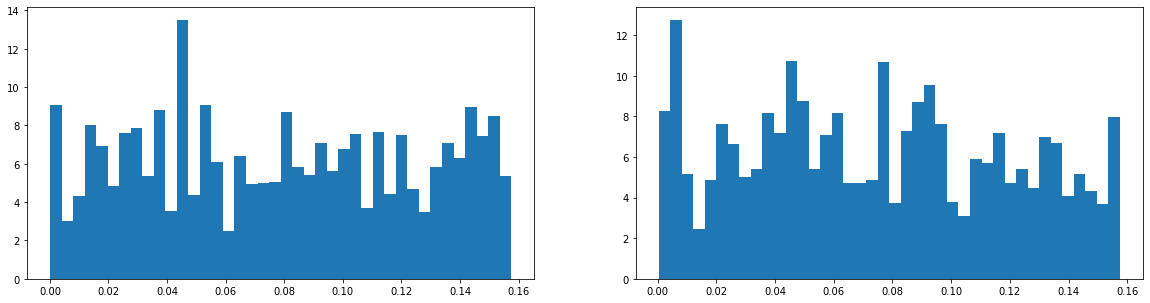

In [64]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
_ = ax[0].hist(target.pdf(mhmc_samples), bins=40, density=True)
_ = ax[1].hist(target.pdf(mhmc_samples_pv), bins=40, density=True)

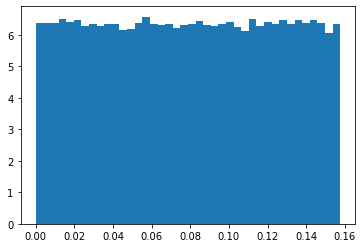

In [65]:
_ = plt.hist(target.pdf(target.rvs(N)), bins=40, density=True)